# Titanic machining learning

## 0. Import library and data

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [97]:
df_train=pd.read_csv("train.csv")
df_train.head()
target=df_train.Survived

In [98]:
df_test=pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1. Data exploration

### 1.1. Missing values

In [99]:
mis_feat=df_train.isnull().sum()
print(mis_feat[mis_feat>0])
mis_feat=df_test.isnull().sum()
mis_feat[mis_feat>0]

Age         177
Cabin       687
Embarked      2
dtype: int64


Age       86
Fare       1
Cabin    327
dtype: int64

### 1.2. Relationship between independent variables(X) and dependent variable(Y)

#### 1.2.1. Numerial variables

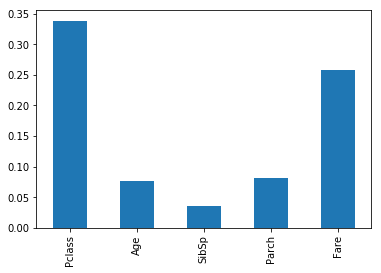

In [100]:
df_train[["Pclass","Age","SibSp","Parch","Fare"]].corrwith(target).apply(np.abs).plot.bar()
plt.show()

#### 1.2.2. Non-numerial variables

female    0.543351
male     -0.543351
dtype: float64

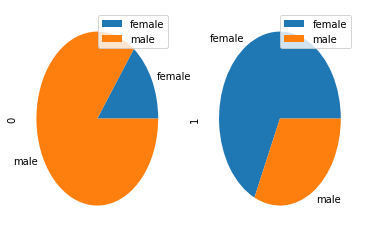

In [101]:
# Sex
pd.crosstab(df_train.Sex,target).plot(kind="pie",subplots=True)
pd.get_dummies(df_train.Sex).corrwith(target)

C    0.16824
Q    0.00365
S   -0.15566
dtype: float64

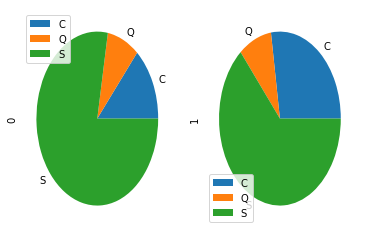

In [102]:
# Embarked
pd.crosstab(df_train.Embarked,df_train.Survived).plot(kind="pie",subplots=True)
pd.get_dummies(df_train.Embarked).corrwith(df_train.Survived)

## 2. Feature engineering

### 2.1. Fill missing values

In [103]:
ndf_train=pd.DataFrame(df_train["Pclass"].copy())
ndf_test=pd.DataFrame(df_test["Pclass"].copy())
# Embarked
most_fre=df_train.Embarked.value_counts().max()
ndf_train["Embarked"]=df_train.Embarked.fillna(most_fre)
ndf_train.head()

,Pclass,Embarked
0,3,S
1,1,C
2,3,S
3,1,S
4,3,S


In [104]:
# Embarked
dum_emb=pd.get_dummies(df_train.Embarked)
print(dum_emb.corrwith(df_train.Survived))

# Add to new data frame
ndf_train=ndf_train.join(pd.get_dummies(df_train.Embarked))
ndf_test=ndf_test.join(pd.get_dummies(df_test.Embarked))
ndf_test.head()

C    0.16824
Q    0.00365
S   -0.15566
dtype: float64


,Pclass,C,Q,S
0,3,0,1,0
1,3,0,0,1
2,2,0,1,0
3,3,0,0,1
4,3,0,0,1


In [105]:
# Fare
all_df=pd.concat([df_train,df_test],join="inner")
all_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


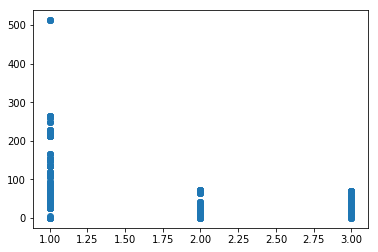

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64


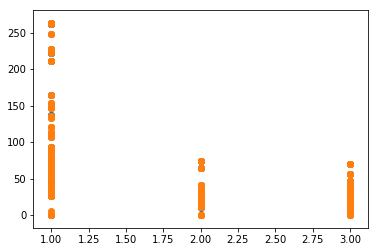

In [106]:
plt.scatter(all_df.Pclass,all_df.Fare)
plt.show()
cl_of_na=all_df.Pclass[all_df.Fare.isna()]
mean_fa_cl=all_df["Fare"].groupby(all_df.Pclass).mean()
print(mean_fa_cl)
#fill na for fare
df_test["Fare"]=df_test.Fare.fillna(mean_fa_cl[3])
df_train["Fare"]=np.where(df_train["Fare"]>300,mean_fa_cl[1],df_train["Fare"])
df_test["Fare"]=np.where(df_test["Fare"]>300,mean_fa_cl[1],df_test["Fare"])
plt.scatter(df_test.Pclass,df_test.Fare)
plt.scatter(df_train.Pclass,df_train.Fare)
plt.show()

In [107]:
# Fare
max=0
for i in range(12,51):
    bins=[-1,11,i,52,600]
    new_Fare=pd.cut(df_train.Fare,bins)
    #print(new_Fare.value_counts())
    #print(pd.crosstab(new_Fare,df_train["Survived"]))
    co=pd.get_dummies(new_Fare).corrwith(df_train.Survived).iloc[2]
    if np.abs(co)>max:
        max=np.abs(co)
        print(i,max)
        

12 0.06912281020827445
15 0.07423755662892721


In [108]:
bins=[-1,11,52,600]
new_Fare=pd.cut(df_train.Fare,bins)
print(new_Fare.value_counts())
print(pd.crosstab(new_Fare,df_train["Survived"]))
pd.get_dummies(new_Fare).corrwith(df_train.Survived)

(11, 52]     378
(-1, 11]     364
(52, 600]    149
Name: Fare, dtype: int64
Survived     0    1
Fare               
(-1, 11]   288   76
(11, 52]   216  162
(52, 600]   45  104


(-1, 11]    -0.299143
(11, 52]     0.078958
(52, 600]    0.289470
dtype: float64

In [109]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Fare,bins,labels=["Fare_low","Fare_mid","Fare_high"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Fare,bins,labels=["Fare_low","Fare_mid","Fare_high"])))
ndf_test.head()

,Pclass,C,Q,S,Fare_low,Fare_mid,Fare_high
0,3,0,1,0,1,0,0
1,3,0,0,1,1,0,0
2,2,0,1,0,1,0,0
3,3,0,0,1,1,0,0
4,3,0,0,1,0,1,0


In [110]:
# Sex
dum_sex=pd.get_dummies(df_train.Sex)
print(dum_sex.corrwith(df_train.Survived))

ndf_train=ndf_train.join(pd.get_dummies(df_train.Sex,drop_first=True))
ndf_test=ndf_test.join(pd.get_dummies(df_test.Sex,drop_first=True))
ndf_test.head()

female    0.543351
male     -0.543351
dtype: float64


,Pclass,C,Q,S,Fare_low,Fare_mid,Fare_high,male
0,3,0,1,0,1,0,0,1
1,3,0,0,1,1,0,0,0
2,2,0,1,0,1,0,0,1
3,3,0,0,1,1,0,0,1
4,3,0,0,1,0,1,0,0


In [111]:
print(pd.crosstab(df_train.Survived,df_train.SibSp))
bins=[-1,0.5,2.5,9]
new_Sib=pd.cut(df_train.SibSp,bins,labels=["S0","S1-2","S>2"])
pd.crosstab(new_Sib,df_train["Survived"])

SibSp       0    1   2   3   4  5  8
Survived                            
0         398   97  15  12  15  5  7
1         210  112  13   4   3  0  0


Survived,0,1
SibSp,,
S0,398,210
S1-2,112,125
S>2,39,7


In [112]:
new_Sib=pd.get_dummies(new_Sib)
new_Sib.corrwith(df_train.Survived)

S0     -0.115867
S1-2    0.177738
S>2    -0.111145
dtype: float64

In [113]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.SibSp,bins,labels=["S0","S1-2","S>2"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.SibSp,bins,labels=["S0","S1-2","S>2"])))
ndf_test.head()

,Pclass,C,Q,S,Fare_low,Fare_mid,Fare_high,male,S0,S1-2,S>2
0,3,0,1,0,1,0,0,1,1,0,0
1,3,0,0,1,1,0,0,0,0,1,0
2,2,0,1,0,1,0,0,1,1,0,0
3,3,0,0,1,1,0,0,1,1,0,0
4,3,0,0,1,0,1,0,0,0,1,0


In [114]:
# Parch
print(pd.crosstab(df_train.Survived,df_train.Parch))
bins=[-1,0.5,3.5,9]
new_Par=pd.cut(df_train.Parch,bins,labels=["0","1-3",">3"])
print(new_Par.value_counts())
new_Par=pd.get_dummies(new_Par)
new_Par.corrwith(df_train.Survived)

Parch       0   1   2  3  4  5  6
Survived                         
0         445  53  40  2  4  4  1
1         233  65  40  3  0  1  0
0      678
1-3    203
>3      10
Name: Parch, dtype: int64


0     -0.147408
1-3    0.165511
>3    -0.062182
dtype: float64

In [115]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Parch,bins,labels=["P0","P1-3","P>3"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Parch,bins,labels=["P0","P1-3","P>3"])))
ndf_test.head()

,Pclass,C,Q,S,Fare_low,Fare_mid,Fare_high,male,S0,S1-2,S>2,P0,P1-3,P>3
0,3,0,1,0,1,0,0,1,1,0,0,1,0,0
1,3,0,0,1,1,0,0,0,0,1,0,1,0,0
2,2,0,1,0,1,0,0,1,1,0,0,1,0,0
3,3,0,0,1,1,0,0,1,1,0,0,1,0,0
4,3,0,0,1,0,1,0,0,0,1,0,0,1,0


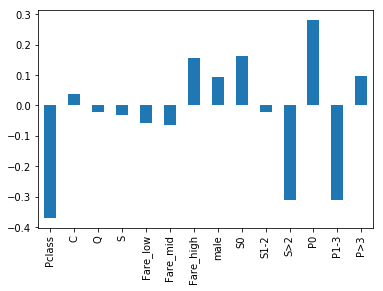

In [116]:
ndf_train.corrwith(df_train.Age).plot.bar()
plt.show()

In [117]:
# Fill na for young people
def young(string):
    youn=False # unable to identify age based on name
    if (string.find("Miss")!=-1) or (string.find("Master")!=-1):
        youn=True

    return youn

kid=df_train["Name"].apply(young)
df_train.Age[kid]=df_train.Age[kid].fillna(6)
kid=df_test["Name"].apply(young)
df_test.Age[kid]=df_test.Age[kid].fillna(6)

C:\Users\Duong Hung\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Duong Hung\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


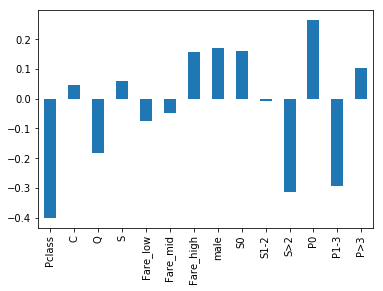

In [118]:
ndf_train.corrwith(df_train.Age).plot.bar()
plt.show()

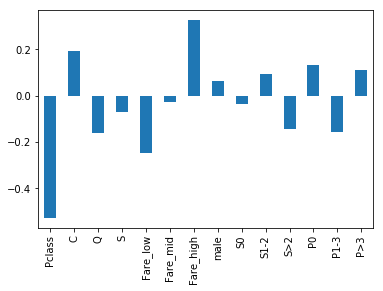

In [119]:
ndf_test.corrwith(df_test.Age).plot.bar()
plt.show()

In [120]:
ndf_train.drop(columns=["Embarked"],inplace=True)

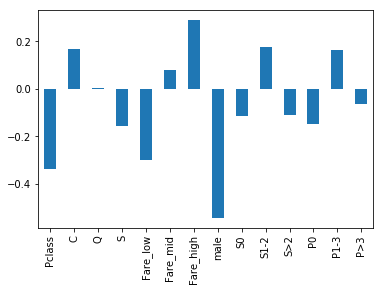

In [121]:
ndf_train.corrwith(df_train.Survived).plot.bar()
plt.show()

In [122]:
selection=["Pclass","Fare_low","Fare_high","male"]
X_train,X_test,y_train,y_test = train_test_split(ndf_train,df_train.Survived,test_size=0.20,random_state=0)
LR= LogisticRegression(solver='lbfgs',multi_class="ovr")
LR.fit(X_train,y_train)
print(LR.score(X_train,y_train))
print(LR.score(X_test,y_test))

0.7963483146067416
0.8156424581005587


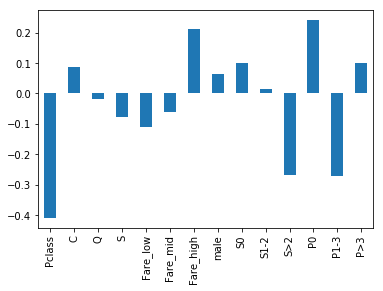

In [123]:
new_all_df=pd.concat([ndf_train,ndf_test])
new_all_df.corrwith(all_df.Age).plot.bar()
plt.show()

In [124]:
# use KRR to predict Age
from sklearn.kernel_ridge import KernelRidge
X=new_all_df[all_df.Age.isna()==False][["Pclass","Fare_high","S>2","P0","P1-3"]]
y=np.array(all_df.Age[all_df.Age.isna()==False])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)
clf_age = KernelRidge(kernel="rbf")
clf_age.fit(X_train,y_train)
clf_age.score(X_test,y_test)


0.2114973629488499

In [125]:
for i in range(-3,4):
    clf_age = KernelRidge(kernel="rbf",alpha=0.1,gamma=10**i)
    clf_age.fit(X_train,y_train)
    print(10**i,clf_age.score(X_test,y_test))
    

0.001 0.17169288419994932
0.01 0.1852972066005244
0.1 0.222176195626268
1 0.21193216701529427
10 0.1911994667190473
100 0.19119505665633607
1000 0.19119505665633607


In [126]:
clf_age = KernelRidge(kernel="rbf",alpha=0.1,gamma=0.1)
clf_age.fit(X_train,y_train)
print(clf_age.score(X_test,y_test))

0.222176195626268


In [127]:
bins=[-1,6,60,150]
new_Age=pd.cut(df_train.Age,bins)
print(new_Age.value_counts())
print(pd.crosstab(new_Age,df_train["Survived"]))
pd.get_dummies(new_Age).corrwith(df_train.Survived)

(6, 60]      645
(-1, 6]       87
(60, 150]     22
Name: Age, dtype: int64
Survived     0    1
Age                
(-1, 6]     30   57
(6, 60]    393  252
(60, 150]   17    5


(-1, 6]      0.183533
(6, 60]      0.022839
(60, 150]   -0.051224
dtype: float64

In [128]:
fill_age=df_train.Age.groupby(new_Age).mean()
fill_age

Age
(-1, 6]       4.231839
(6, 60]      30.425581
(60, 150]    66.022727
Name: Age, dtype: float64

In [129]:
X=new_all_df[all_df.Age.isna()==False][["Pclass","Fare_high","S>2","P0","P1-3"]]
y=np.array(all_df.Age[all_df.Age.isna()==False])
bins=[-1,6,60,150]
y=pd.cut(y,bins)
X_train,X_test,y_train,y_test = train_test_split(X,y.codes,test_size=0.20,random_state=0)
clf_age = LogisticRegression(solver='lbfgs',multi_class="ovr")
clf_age.fit(X_train,y_train)
clf_age.score(X_test,y_test)

0.9333333333333333

(array([  0.,   0.,   0.,   0.,   0., 263.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

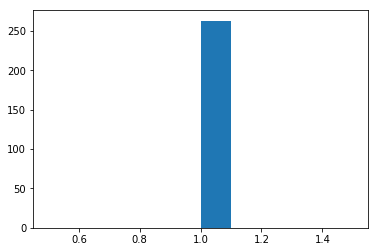

In [130]:
X_na=new_all_df[all_df.Age.isna()][["Pclass","Fare_high","S>2","P0","P1-3"]]
pred_age=clf_age.predict(X_na)
plt.hist(pred_age)

In [131]:
df_train.Age.fillna(30,inplace=True)
df_test.Age.fillna(30,inplace=True)

In [132]:
df_train.Age.isna().sum()

0

In [133]:
bins=[-1,6,60,150]
new_Age=pd.cut(df_train.Age,bins)
print(new_Age.value_counts())
print(pd.crosstab(new_Age,df_train["Survived"]))
pd.get_dummies(new_Age).corrwith(df_train.Survived)

(6, 60]      782
(-1, 6]       87
(60, 150]     22
Name: Age, dtype: int64
Survived     0    1
Age                
(-1, 6]     30   57
(6, 60]    502  280
(60, 150]   17    5


(-1, 6]      0.183533
(6, 60]     -0.142000
(60, 150]   -0.051224
dtype: float64

In [134]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Age,bins,labels=["A1","A2","A3"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Age,bins,labels=["A1","A2","A3"])))
ndf_train.head()

,Pclass,C,Q,S,Fare_low,Fare_mid,Fare_high,male,S0,S1-2,S>2,P0,P1-3,P>3,A1,A2,A3
0,3,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0
1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
2,3,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0
3,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,3,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0


In [135]:
ndf_train["Fs"]=df_train.SibSp+df_train.Parch

In [136]:
ndf_train["Alone"]=np.where((df_train.SibSp==0)&(df_train.Parch==0),1,0)

In [137]:
ndf_test["Fs"]=df_test.SibSp+df_test.Parch
ndf_test["Alone"]=np.where((df_test.SibSp==0)&(df_test.Parch==0),1,0)

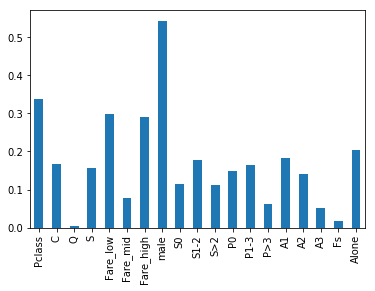

In [138]:
ndf_train.corrwith(target).abs().plot.bar()

In [139]:
relation=ndf_train.corrwith(target).abs()
selection=relation[relation>0.1].index

In [140]:
X_train,X_test,y_train,y_test = train_test_split(ndf_train,df_train.Survived,test_size=0.2,random_state=45)
LR= LogisticRegression(solver='lbfgs',multi_class="ovr")
LR.fit(X_train,y_train)
print(LR.score(X_train,y_train))
print(LR.score(X_test,y_test))

0.8019662921348315
0.8212290502793296


In [141]:
X_train,X_test,y_train,y_test = train_test_split(ndf_train[selection],df_train.Survived,test_size=0.2,random_state=45)
LR= LogisticRegression(solver='lbfgs',multi_class="ovr")
LR.fit(X_train,y_train)
print(LR.score(X_train,y_train))
print(LR.score(X_test,y_test))


0.8047752808988764
0.8156424581005587


In [142]:
for i in range(-3,4):
    clf = SVC(C=1000,gamma=10**i)
    clf.fit(X_train,y_train)
    print(i)
    s_te=clf.score(X_test,y_test)
    s_tr=clf.score(X_train,y_train)
    print(s_tr,s_tr-s_te)

-3
0.8117977528089888 -0.048537442721737434
-2
0.8300561797752809 -0.013519239219132562
-1
0.848314606741573 -0.01760718096792424
0
0.848314606741573 -0.012020588789153241
1
0.848314606741573 0.0047391877471595345
2
0.848314606741573 0.0047391877471595345
3
0.848314606741573 0.0047391877471595345


In [143]:
clf = SVC(C=100,gamma=0.1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train,y_train))
clf.score(X_test,y_test)

0.8455056179775281


0.8715083798882681

In [162]:
clf = SVC(C=100,gamma=0.1)
clf.fit(ndf_train[selection],df_train.Survived)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [144]:
from sklearn.neighbors import KNeighborsClassifier

In [145]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.8174157303370787 -0.026159688657334756


In [146]:
for i in [10,20,30,40,50,60,70,80,100]:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    s_te=clf.score(X_test,y_test)
    s_tr=clf.score(X_train,y_train)
    print(i,s_tr,s_tr-s_te)

10 0.800561797752809 -0.059773397777917237
20 0.7893258426966292 -0.009556838867616602
30 0.7879213483146067 -0.04448088632226477
40 0.7696629213483146 -0.06832590546732786
50 0.75 -0.08798882681564246
60 0.7668539325842697 -0.06554830205260176
70 0.7570224719101124 -0.05861998619044628
80 0.7303370786516854 -0.0741321950913314
100 0.7373595505617978 -0.05593653882367711


In [147]:
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.7893258426966292 -0.009556838867616602


In [148]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [149]:
clf = LDA(solver="lsqr")
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.7907303370786517 -0.03608530537944887


In [150]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [151]:
clf = QDA()
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.7682584269662921 -0.0362108467767247


C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [152]:
from sklearn.tree import DecisionTreeClassifier as DTC # Import Decision Tree Classifier

In [153]:
clf = DTC()
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.848314606741573 -0.012020588789153241


In [154]:
from sklearn.model_selection import GridSearchCV
clf = DTC()
param_grid = {"criterion":["gini","entropy"],"splitter":["best","random"],
              'max_depth' : np.arange(2, 9, dtype=int),
              'min_samples_leaf' :  np.arange(1, 3, dtype=int)}
search = GridSearchCV(clf, param_grid,scoring='accuracy', cv=10)
search.fit(X_train,y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'splitter': 'random'}

In [155]:
clf = DTC(max_depth=3,min_samples_leaf=1)
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.8146067415730337 -0.0792480070303182


In [156]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC()
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.8469101123595506 -0.007838490992404745


C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [157]:
clf = RFC()
param_grid = {"n_estimators":[50,100],"criterion":["gini","entropy"],
              'max_depth' : np.arange(2, 9, dtype=int),
              'min_samples_leaf' :  np.arange(1, 3, dtype=int)}
search = GridSearchCV(clf, param_grid,scoring='accuracy', cv=10)
search.fit(X_train,y_train)
search.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [158]:
clf = RFC(n_estimators=100,max_depth=4, min_samples_leaf=2)
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.8230337078651685 -0.05964785638064152


In [159]:
from sklearn.ensemble import BaggingClassifier
clf = RFC(n_estimators=100,max_depth=4, min_samples_leaf=2)
clf = BaggingClassifier(base_estimator=clf,n_estimators=10, random_state=0)
clf.fit(X_train,y_train)
s_te=clf.score(X_test,y_test)
s_tr=clf.score(X_train,y_train)
print(s_tr,s_tr-s_te)

0.8216292134831461 -0.06105235076266391


In [163]:
y_pred=clf.predict(ndf_test[selection])
submission=pd.DataFrame()
submission["PassengerId"]=df_test.PassengerId
submission["Survived"]=y_pred
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [164]:
submission.to_csv("SVC_submission_4.csv",index=False)